## Practical exercises. Part II

### Andrey Kravtsov

### The University of Chicago 

### email: kravtsov@uchicago.edu

Two exercises included below concern relation between galaxy luminosity and total gravitating mass of collapsed halos. The first two exercises are straightforward and only require running provided codes for computing halo mass function and galaxy luminosity function in the SDSS sample. 

The third exercises involves implementation of so-called "abundance matching ansatz" to derive relation between collapsed halo mass and galaxy stellar mass at different redshifts. This exercise is more involved. 

Try to carry out at least the first two exercises and attempt the third one if you are comfortable with concepts and required numerical methods. 

In [1]:
# boiler plate auxiliary stuff
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from codes.plot_utils import plot_pretty
plot_pretty()

### 1. Comparing galaxy luminosity function and halo mass function at z=0

#### Background.
During lecture 3 I discussed some of the differences in the shapes of galaxy luminosity function (LF) and halo mass function (MF, e.g., "faint-end" slope and sharpness of the exponential cutoff. Let's explore some of the implications of these differences for certain interesting quantities.

#### Task. 

Plot the luminosity of SDSS galaxies in the Meert et al. SDSS catalog and halo mass function given by the ellipsoidal collapse for standard $\Lambda$CDM model worked out Sheth et al. (2001) and calibrated using results of cosmological simulations side by side on the same plot. 

Is there any obvious feature in the halo mass function at the number density of the exponential cutoff in  the LF? What does this tell you about the origin of this cutoff? 

The codes to compute luminosity function and halo mass function are provided below

#### Code to compute halo mass function. 

In [2]:

from colossus.cosmology import cosmology
from colossus.lss import peaks

#
#  SMT01 mass function parameters
#
q_smt = 0.3; A_smt = 0.322; a_smt = 0.707

def hmf_smt01(mh, zm, cosmo): 
    """
    return halo mass function in the Sheth, Mo & Tormen (2001) approximation:
    
    parameters:
    -----------
        mh: float array like
            halo masses in /h Msun
        zm: float
            redshift
        cosmo: python class object
    returns:
    --------
        dn/dlnM - array like mh
            in h^3 Mpc^-3
    """
    # compute Lagrangian radius corresponding to perturbation of mass mh in /h Mpc
    rh = peaks.lagrangianR(mh)
    # compute rms fluctuation sigma(R) using default Eisenstein & Hu 1998 power spectrum and tophat filter
    sig = cosmo.sigma(rh,zm)
    # and its logarithmic derivative dlog(sigma)/dlogR
    dsdr = cosmo.sigma(rh, zm, derivative='True')
    # dln(sigma)/dlnR -> dln(sigma)/dlnM, M = (4*pi/3) rho_mean * R^3
    dsdm = dsdr / 3.0

    nu = peaks.peakHeight(mh, zm)
    nup = np.sqrt(a_smt)*nu
    dsdmz = dsdm*cosmo.growthFactor(zm)
    nsmt = A_smt*np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh*(1.0+1./nup**(2.*q_smt))*nup*np.abs(dsdm)*np.exp(-0.5*nup**2)
    
    return nsmt
    

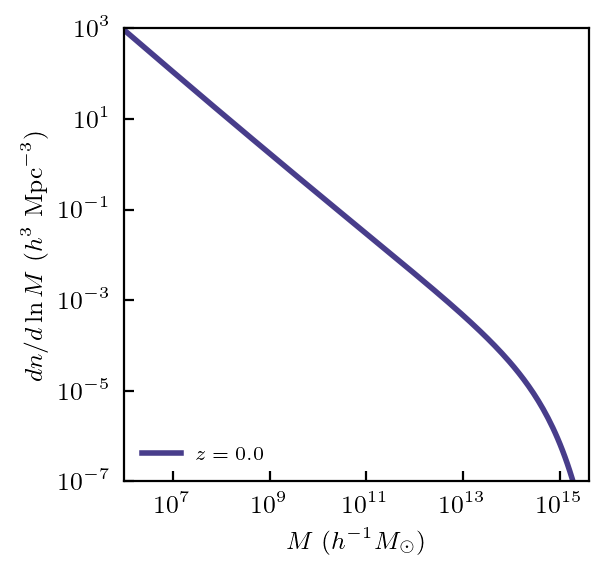

In [3]:
from colossus.cosmology import cosmology
from colossus.lss import peaks
import matplotlib.cm as cm
import matplotlib.colors as colors

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.3, 'Ob0': 0.045714, 'sigma8': 0.81, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
#cosmo.interpolation = False

z = 0.0
# grid of halo masses in /h Msun
lmh = np.arange(6.,15.5,0.05)
mh = np.power(10.,lmh)

# compute mass function using Sheth et al. 2001 approximation
nsmt = hmf_smt01(mh, z, cosmo)

plot_pretty(dpi=200)
fig = plt.figure(figsize = (3,3))
plt.xlabel(r'$M\ (h^{-1} M_{\odot})$'); plt.ylabel(r'$dn/d\ln M\ (h^3\ \rm Mpc^{-3})$')
plt.yscale('log'); plt.xscale('log')
plt.xlim(1.e6, 4.e15); plt.ylim(1.e-7,1.e3)

plt.plot(mh, nsmt,c='darkslateblue', linewidth=2.0, label=r'$z=%.1f$'%z)
plt.legend(frameon=False, loc='lower left', fontsize=7)
plt.show()

#### Code to compute luminosity function of galaxies in the SDSS sample

In [4]:
from codes.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 
# 4=DeVExp, 5=SerExp
datadir = r'data/Meert2015_v2/'
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(datadir, phot_type=1)

670722 galaxies in Meert et al. sample initially


In [5]:
# lower limit on z is to avoid the nearest galaxies for which SDSS pipeline often does 
# not perform well (splitting them into pieces, etc)
# with z_min=0.005 we are excluding galaxies closer than the Virgo cluster ~16 Mpc away from the Milky Way
# z_max=1.0 is to avoid misclassified objects that appear as very high z systems
z_min = 0.005; z_max = 0.4

# magnitude cuts appropriate for the SDSS main spectroscopic sample 
m_min = 12; m_max = 17.77

mrm = phot_r['petroMag'] - mnpdata['extinction']
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']

# apply redshift, magnitude, and color cuts
isel = (sdata['z'] > z_min) & (sdata['z'] < z_max) & ( mrm > m_min) & (mrm < m_max) & (grm>-2.5) & (grm<2.5)


zm = sdata['z'][isel]; mmeert = mdata['m_tot'][isel]
mpetro = phot_r['petroMag'][isel] - mnpdata['extinction'][isel]

extm = mnpdata['extinction'][isel]; kcorr = mnpdata['kcorr'][isel]

print("selected %d galaxies"%np.shape(zm))


selected 236877 galaxies


In [6]:
# now compute luminosity and angular diameter distances for galaxies in the sample
from codes.cosmology import d_l

# define suitable cosmological parameters
# the same as for the halo mass function above
h = cosmo.h # H0/100
Om0 = cosmo.Om0; OmL = cosmo.Ode0
d_H = 2997.92 # c/(100 km/s/Mpc) 

d_L = d_l(zm, Om0, OmL, ninter=20)
d_A = d_L / (1.+z)**2

# dimensionless distance -> Mpc 
d_L *= d_H / h; d_A *= d_H /h 


# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_L/1e-5) - extm + 1.3*zm - kcorr; 

# absolute Petrosian magnitude in the r-band corrected for extinction, evolution, and k-correction
Mpetro = mpetro - 5.0*np.log10(d_L/1e-5) - extm + 1.3*zm - kcorr; 
# 4.67 is the r-band abs. magntidue of the Sun
# compute log10(L) 
Lmeert =  0.4*(4.67-(Mmeert));

# inverse Vmax. In this catalog pre-computed Vmax is provided 
#vmaxi = 1.0/vmaxm[ilim]/3.0

d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetro))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetro))/(1.+zm)

vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.93
# 0.195 is the fraction of total sky solid angle that is covered by the UPenn photometric catalog, 
# as reported by them
solid_anglem = 4.*np.pi/3*0.195
# 1/Vmax
vmaxim = vmaxim / (solid_anglem*ccm)


In [7]:
# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 20; nbins = 80

# luminosity function is just a histogram weighed by inverse Vmax volume
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

#normalize and scale LF properly + onvert from dn/dlog10(L) to dn/dln(L)
phi_Lmeert = phi_Lmeert  / dLbins / h**3 / np.log(10.)


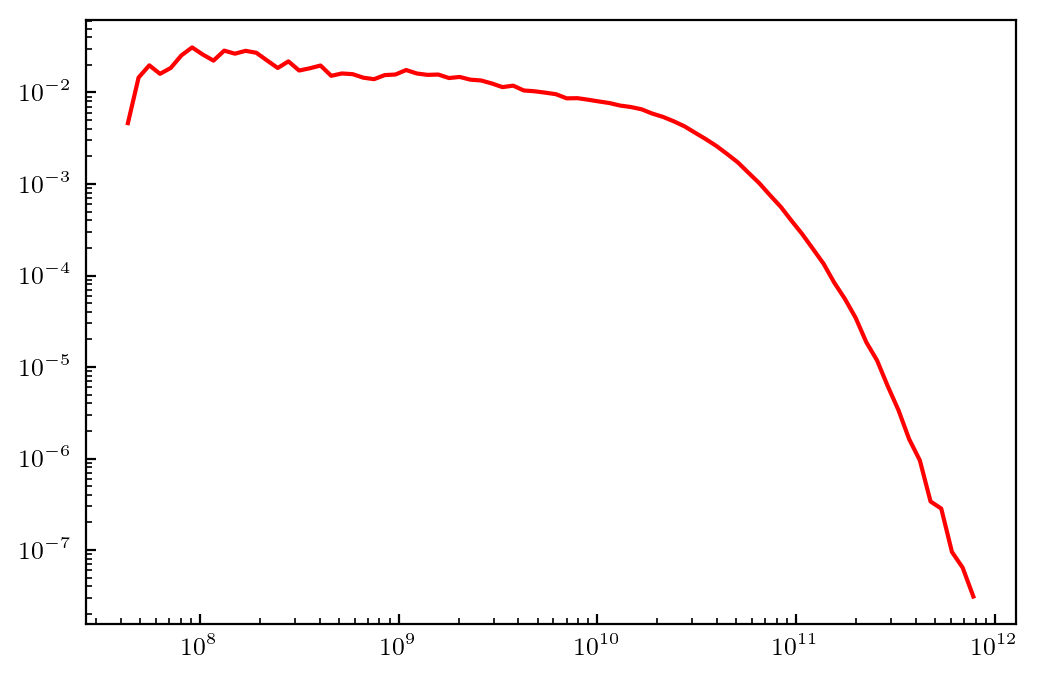

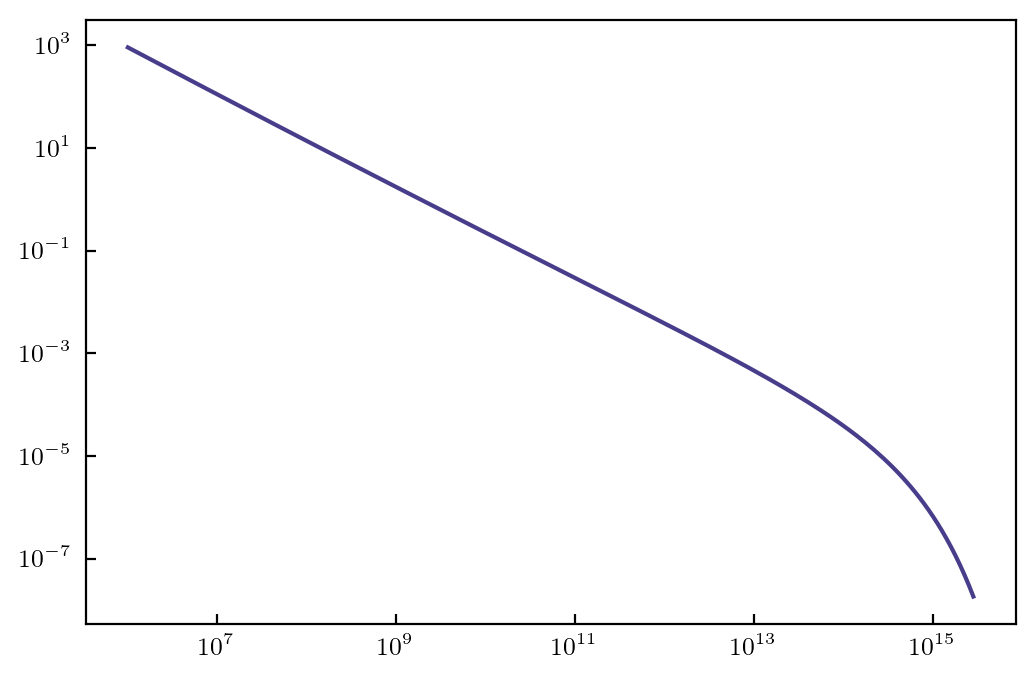

In [8]:
binc = 10**Lbinc
plt.loglog(binc, phi_Lmeert,c='red')
plt.show()
plt.loglog(mh, nsmt,c='darkslateblue')
plt.show()

Lbinc and phi_Lmeert arrays now contain binned log10(L) and dn/dln L 

### 2. Analyze and compare evolution of halo mass function and stellar mass function of galaxies 

#### Background. 
In the standard CDM structure formation scenario, observed galaxies form in extended dark matter halo dominated by non-baryonic dark matter. The mass function of the latter can be predicted by models or  calibrated with numerical simulations. 

The stellar mass function of galaxies at different redshifts can be inferred from observations. Comparing halo mass function at different $z$ to galaxy stellar mass function informs on how stellar masses are related to total gravitating masses of galaxies, which, in turn, informs and constrains galaxy formation models.

#### Task. 
Use code below to plot evolution of stellar mass function of galaxies and mass function of collapsed halos at different redshifts. Compare the evolution of these functions and try to identify the most salient differents *and* similarities. 

In [9]:
import matplotlib.colors as colors
from scipy.interpolate import UnivariateSpline

def nmstz(ms, z):
    """
    compute analytic double Schechter representation of the observed stellar mass function as a function
    of redshift using calibration of Leja et al. 2015, 798, 115 (see eqs in their S 2)
    note that this calibration is for 3<z<0 - I checked it gives grossly incorrect results at z>3
    z>3 estimate is taken from Song et al. 2015 instead. 
    
    input: ms - array of stellar masses
            z - redshift
    output: dn/dlog10(M*) in dex^-1 Mpc^-3
    """
    if z <= 3.0:
        z2 = z * z; lms = np.log10(ms)
        lphi1 = -2.46 + 0.07*z - 0.28*z2 
        lphi2 = -3.11 - 0.18*z - 0.03*z2
        lmst  = 10.72 - 0.13*z + 0.11*z2
        mst = np.power(10.,lmst); mus = ms/mst
        a1 = -0.39; a2 = -1.53
        nmstz = np.log(10.)*np.exp(-mus)*(mus)*(10.**lphi1*mus**a1+10.**lphi2*mus**a2)
    else:
        """
        high-z SMF estimates from CANDELS and S-CANDELS from the talk by Song 
        http://www.astrodeep.eu/wp-content/uploads/2015/02/MSong.sesto_.Jan2015.pdf
        """
        z_h     = [4.0, 5.0, 6.0, 7.0]
        lmst_z  = [10.68, 10.58, 10.22, 10.45]
        ah_z    = [-1.59, -1.68, -1.89, -1.93]
        lphi_z = [-3.77, -3.99, -4.34, -4.94]

        lmst  = UnivariateSpline(z_h, lmst_z)
        ahz   = UnivariateSpline(z_h, ah_z)
        lphiz = UnivariateSpline(z_h, lphi_z)
        a = ahz(z); mst = np.power(10., lmst(z)); phiz = np.power(10.,lphiz(z))
        mus = ms/mst
        nmstz = np.log(10.)*phiz*np.exp(-mus)*(mus)**(a + 1.0)

    return nmstz


lms = np.arange(6., 12.6, 0.01)
ms = np.power(10., lms)

philejaz0 = nmstz(ms,0.0)


[5.67303529e-01 5.60422428e-01 5.53624792e-01 5.46909610e-01
 5.40275882e-01 5.33722618e-01 5.27248844e-01 5.20853595e-01
 5.14535919e-01 5.08294875e-01 5.02129533e-01 4.96038976e-01
 4.90022295e-01 4.84078596e-01 4.78206993e-01 4.72406611e-01
 4.66676586e-01 4.61016066e-01 4.55424207e-01 4.49900176e-01
 4.44443151e-01 4.39052319e-01 4.33726878e-01 4.28466033e-01
 4.23269001e-01 4.18135010e-01 4.13063293e-01 4.08053096e-01
 4.03103672e-01 3.98214284e-01 3.93384205e-01 3.88612714e-01
 3.83899102e-01 3.79242666e-01 3.74642713e-01 3.70098557e-01
 3.65609522e-01 3.61174940e-01 3.56794149e-01 3.52466498e-01
 3.48191342e-01 3.43968044e-01 3.39795976e-01 3.35674516e-01
 3.31603050e-01 3.27580972e-01 3.23607682e-01 3.19682590e-01
 3.15805110e-01 3.11974666e-01 3.08190686e-01 3.04452607e-01
 3.00759873e-01 2.97111933e-01 2.93508244e-01 2.89948270e-01
 2.86431480e-01 2.82957351e-01 2.79525365e-01 2.76135012e-01
 2.72785785e-01 2.69477187e-01 2.66208724e-01 2.62979911e-01
 2.59790265e-01 2.566393

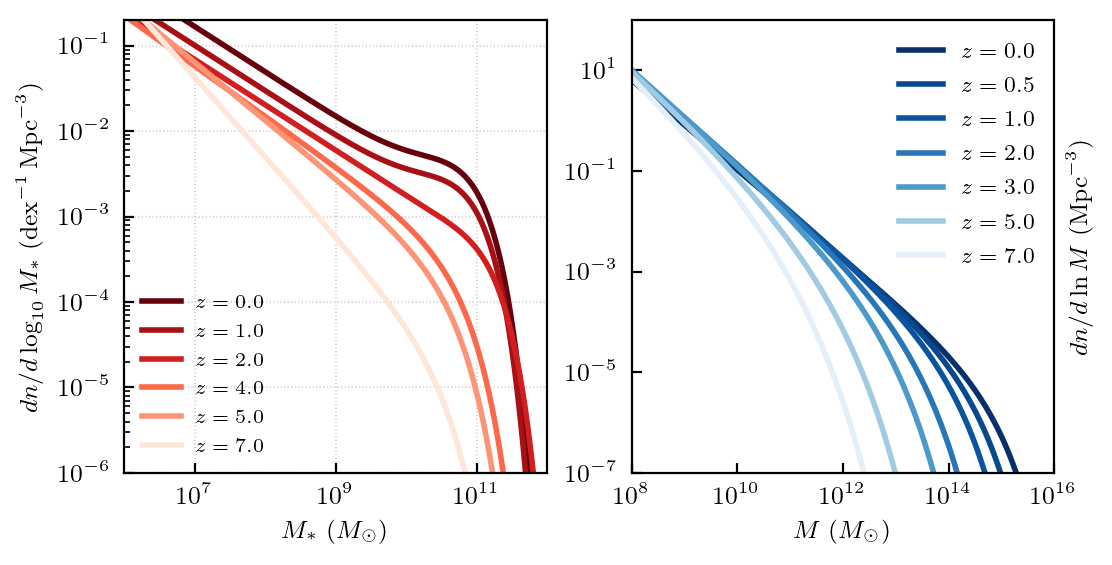

In [31]:

# plot
#
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].set_xlabel(r'$M_*\ (M_{\odot})$')
ax[0].set_ylabel(r'$dn/d\log_{10} M_{*}\ \mathrm{(dex^{-1}\, Mpc^{-3})}$')
ax[0].set_xlim(1.e6, 1.e12); ax[0].set_ylim(1.e-6,0.2)
ax[0].set_xscale('log'); ax[0].set_yscale('log')

cnorm  = colors.Normalize(vmin=0, vmax=22)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.Reds)

z = [0.0, 1.0, 2.0, 4.0, 5.0, 7.0]
for zd in z:
    nc = int(22.*(8.0-zd)/8.0)
    color = scalarmap.to_rgba(nc)

    phiz = nmstz(ms,zd)
    ax[0].plot(ms,phiz,c=color, lw=2.0, label=r'$z=%.1f$'%zd)
print(nmstz(ms,0),ms)
ax[0].legend(frameon=False, loc='lower left', fontsize=7)
ax[0].grid(linestyle='dotted', c='lightgray')
#
# plot
#
cnorm  = colors.Normalize(vmin=0, vmax=22)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.Blues)

ax[1].set_xlabel(r'$M\ (M_{\odot})$'); 
ax[1].set_ylabel(r'$dn/d\ln M\ (\rm Mpc^{-3})$')
ax[1].set_yscale('log'); ax[1].set_xscale('log')
ax[1].set_xlim(1.e8, 1.e16); ax[1].set_ylim(1.e-7,100.)
ax[1].yaxis.set_label_position('right')

z = np.array([0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0])
for zd in z:
    nc = int(22.*(8.0-zd)/8.0)
    color = scalarmap.to_rgba(nc)
    nsmt = hmf_smt01(mh, zd, cosmo) #mh=M_halo*h/M_solar i.e. has units of M_solar/h
    ax[1].plot(mh/cosmo.h,nsmt*cosmo.h**3,c=color,linewidth=2.0, label=r'$z=%.1f$'%zd)
    #so mh/h is M_halo/M_solar i.e. M_halo in units of M_solar

ax[1].legend(frameon=False, loc='upper right', fontsize=8)

plt.show()

### 3. Galaxy luminosity-halo mass relation from the abundance matching ansatz

#### Background. 

The abundance matching (AM) ansatz was developed over the past 15 years to probe connection between observed properties of galaxies and mass of the halos that host them. The AM ansatz is motivated by the fact that all  galaxies in the CDM scenario are assumed to form in the centers of host dark matter halos. It further assumes that scatter between stellar mass and halo mass is small, so one can derive $M_*-M_{\rm h}$ relation simply by matching stellar mass function and halo mass function at the same $z$:
$$n_{\rm g}(>M_*)=n_{\rm h}(>M_h),$$
i.e., matching cumulative stellar mass and halo mass functions. A somewhat more sophisticated versions of the matching that allow one to account for scatter are easy to develop, but we will not consider them here for simplicity as simple approach above is sufficiently accurate for most of the galaxy luminosity range. 

For this exercise to be more accurate we also need to account not only for the "isolated" halos described by the halo mass function expressions, but also for the satellite halos (aka subhalos) which exist inside the isolated host halos. For this, you can use the subhalo fraction as a function of mass calibrated by <a href="http://adsabs.harvard.edu/abs/2013ApJ...770...57B">Behroozi et al. 2013</a> in their equations G5-G7 in Appendix G. To account for satellite halos, multiply the SMT mass functions above by $1+f_{\rm sub}$, where $f_{\rm sub}$ is given by function <tt>fsub</tt> the code below.

In addition to luminosity function, in such abundance matching people often use *stellar mass function* - i.e., distribution of galaxy stellar masses (as opposed to luminosity). Relation between galaxy stellar mass and luminosity is not trivial and requires *population synthesis modeling* that we will discuss later. The conversion from luminosity to stellar mass for observed galaxies is thus model dependent, yet is made often in the literature. These models predict that for galaxies with properties of the Milky Way, for example (e.g., color), $M_\star\approx 2\, (M_\odot/L_{\odot, r}) L_r$.  Below we will take estimates of galaxy stellar mass functions at different redshifts from a recent compilation by <a href="http://adsabs.harvard.edu/abs/2015ApJ...798..115L">Leja et al. 2015</a> and will carry out abundance matching at a number of redshifts using these functions. 

#### Tasks: 

* Plot the evolution of the observed stellar mass function, the distribution of stellar masses of galaxies, described by equations in S 2 of <a href="http://adsabs.harvard.edu/abs/2015ApJ...798..115L">Leja et al. 2015</a>,  for $0<z<2.5$ and single Schechter fit from the CANDELS and CANDELS-S surveys at $z>3$, which is implemented in the script below as function <tt>nmstz</tt>. Comment on differences and similarities to the evolution of halo mass function shown below. <br> 

* Dervice $M_\star-M_h$ relation at diffeent redshifts via the abundance matching approeach using the Leja et al. stellar mass functions and Sheth et al. (2001) mass function with $f_{\rm sub}$ correction. How does the $M_\star-M_h$ relation evolve? 

You can compare your results with results presented in Figure 7 of <a href="http://adsabs.harvard.edu/abs/2013ApJ...770...57B">Behroozi et al. 2013.</a> Discuss inferences for the process of galaxy formation that you can glean from this plot. 

#### Hints and additional considerations:

* Note that when you integrate you should integrate over variable on which integrand is defined, e.g.: 
$$N(>M)=\int_M^{\infty}\frac{dn}{dM}dM=\int_{\rm ln M}^\infty \frac{dn}{d\ln M}d\ln M=\int_{\rm log_{10} M}^\infty \frac{dn}{d\log_{10} M}d\log_{10} M,$$
so depending the choice of how to integrate, if you use spline integration, you should spline $dn/d\log_{10}M$ as a function of $\log_{10} M$, or $dn/d\ln M$ as a function of $\ln M$ etc. Likewise, if you use integration routines you should use integration limits corresponding to the integration variable you choose. Below is a simple example showing how to spline tabulated functions and integrate them. 

* To compute the cumulative functions from differential function you can use one of the integration routines in <a href="http://docs.scipy.org/doc/scipy/reference/integrate.html">scipy.integrate</a>. To solve the above abundance matching numerically, approximate $n_g(>L)$ and $n_h(>M_h)$ by <a href="http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.UnivariateSpline.html">splines</a> and use the splines to get $L-M_h$ relations. See codes below for additional info and examples of how to spline and integrate.

In [78]:
def f1(lnMstar, z): #dn/dlnMstar
    return 1/np.log(10)*nmstz(np.exp(lnMstar),z) 

def f2(lnMhalo, z): #dn/dlnMhalo
    return hmf_smt01(np.exp(lnMhalo)*cosmo.h,z,cosmo)*cosmo.h**3*(1+fsub(np.exp(lnMhalo),z))

In [79]:
import scipy.integrate.quadrature as quadrature
from scipy.integrate import quad

def n1(Mstar_min, z): #n(mass>Mstar_min)
    return quad(f1,np.log(Mstar_min),np.log(10**17), args=(z))[0]
def n2(Mhalo_min, z): #n(mass>Mhalo_min)
    return quad(f2,np.log(Mhalo_min),np.log(10**17), args=(z))[0]

In [142]:
N=100
minMasses1=np.logspace(6,12,N)
minMasses2=np.logspace(6,15,N)
results1=[]
results2=[]
for minMass in minMasses1:
    results1.append(n1(minMass,0))
    results1a.append(n1(minMass,1))
for minMass in minMasses2:
    results2.append(n2(minMass,0))

In [143]:
def Mstar_of_Mhalo(Mhalo,z):
    nMatching=n2(Mhalo,z)
    for index in range(N):
        n1 = results[index]
        Mstar=10**10
        if (n1 < nMatching):
            Mstar = minMasses1[index]
            break
    return Mstar

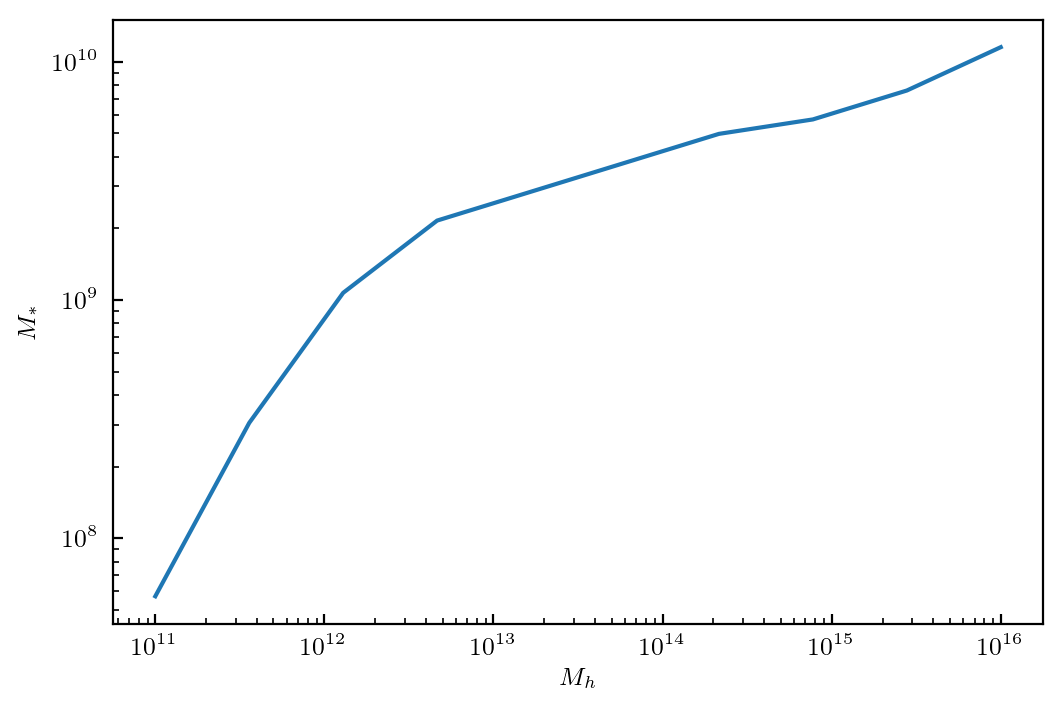

In [145]:
mHaloPlot=np.logspace(11,16,10)
mStarPlot = []
for m in mHaloPlot:
    mStarPlot.append(Mstar_of_Mhalo(m,0))
plt.loglog(mHaloPlot, mStarPlot)
plt.ylabel("$M_*$")
plt.xlabel("$M_h$")
plt.show()

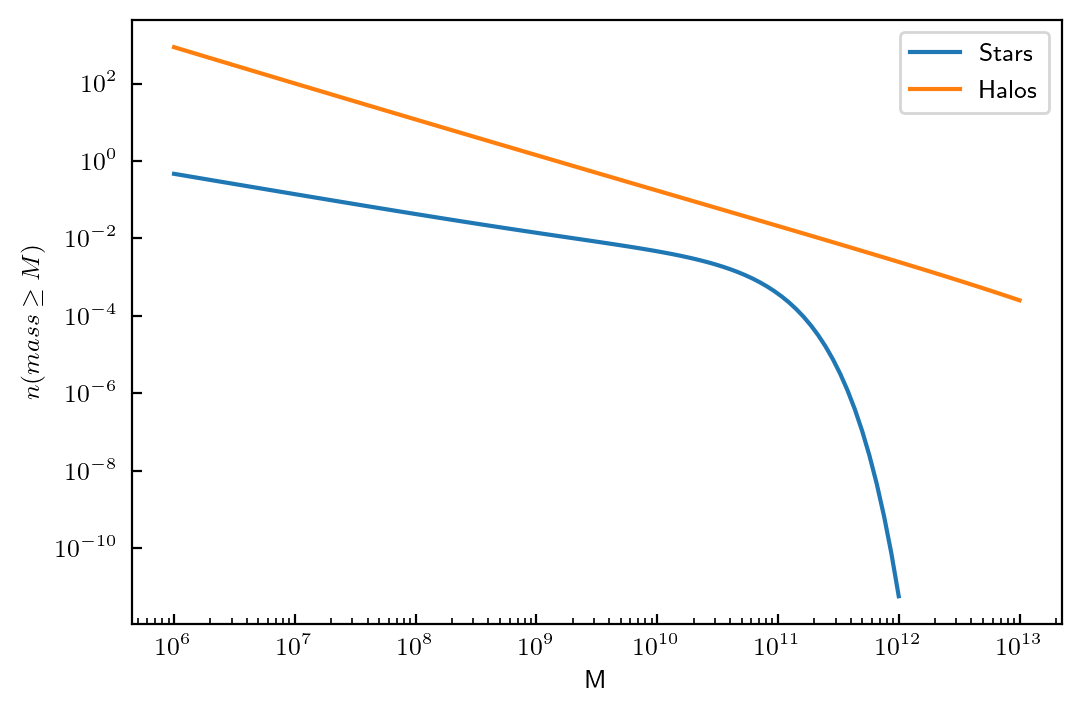

In [132]:
plt.loglog(minMasses1,results1,label="Stars")
plt.loglog(minMasses2,results2,label="Halos")
plt.ylabel("$n(mass\ge M)$")
plt.xlabel("M")
plt.legend()
plt.show()

 ### Example codes to compute various things that are need for exercise described above

In [14]:
import matplotlib.cm as cm
import matplotlib.colors as colors

def nmstz(ms, z):
    """
    compute analytic double Schechter representation of the observed stellar mass function as a function
    of redshift using calibration of Leja et al. 2015, 798, 115 (see eqs in their S 2)
    note that this calibration is for 3<z<0 - I checked it gives grossly incorrect results at z>3
    z>3 estimate is taken from Song et al. 2015 instead. 
    
    input: ms - array of stellar masses
            z - redshift
    output: dn/dlog10(M*) in dex^-1 Mpc^-3
    """
    if z <= 3.0:
        z2 = z * z; lms = np.log10(ms)
        lphi1 = -2.46 + 0.07*z - 0.28*z2 
        lphi2 = -3.11 - 0.18*z - 0.03*z2
        lmst  = 10.72 - 0.13*z + 0.11*z2
        mst = np.power(10.,lmst); mus = ms/mst
        a1 = -0.39; a2 = -1.53
        nmstz = np.log(10.)*np.exp(-mus)*(mus)*(10.**lphi1*mus**a1+10.**lphi2*mus**a2)
    else:
        """
        high-z SMF estimates from CANDELS and S-CANDELS from the talk by Song 
        http://www.astrodeep.eu/wp-content/uploads/2015/02/MSong.sesto_.Jan2015.pdf
        """
        z_h     = [4.0, 5.0, 6.0, 7.0]
        lmst_z  = [10.68, 10.58, 10.22, 10.45]
        ah_z    = [-1.59, -1.68, -1.89, -1.93]
        lphi_z = [-3.77, -3.99, -4.34, -4.94]

        lmst  = UnivariateSpline(z_h, lmst_z)
        ahz   = UnivariateSpline(z_h, ah_z)
        lphiz = UnivariateSpline(z_h, lphi_z)
        a = ahz(z); mst = np.power(10., lmst(z)); phiz = np.power(10.,lphiz(z))
        mus = ms/mst
        nmstz = np.log(10.)*phiz*np.exp(-mus)*(mus)**(a + 1.0)

    return nmstz


lms = np.arange(6., 12.6, 0.01)
ms = np.power(10., lms)

philejaz0 = nmstz(ms,0.0)


In [15]:
def fsub(mh, z):
    """
    subhalo fraction calibration from the Appendix G of Behroozi et al. 2013
    as a function of Mpeak - eqs G9-10
    input: mh = halo mass in Msun
           z  = redshift
    """
    aexp = 1.0/(1.0+z)
    aexp2 = aexp*aexp; aexp3 = aexp2*aexp; aexp4 = aexp3*aexp
    Ca = -1.91 + 6.23*aexp - 15.07*aexp2 + 15.02*aexp3  - 5.29*aexp4
    Mcutoff = 10.66 + 15.93*aexp - 21.39*aexp2 + 18.20*aexp3 - 8.21*aexp4
    return 10.**Ca*np.log10(10.**Mcutoff/mh)



The code below illustrates three ways of how integral can be computed - one by integrating a function defined using spline using a library or romberg routine in code/auxiliary.py, and the second using the integral method of spline itself. The latter, however, requires that the function under the integral is splined. This is not always convenient or accurate, but will work here. 

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


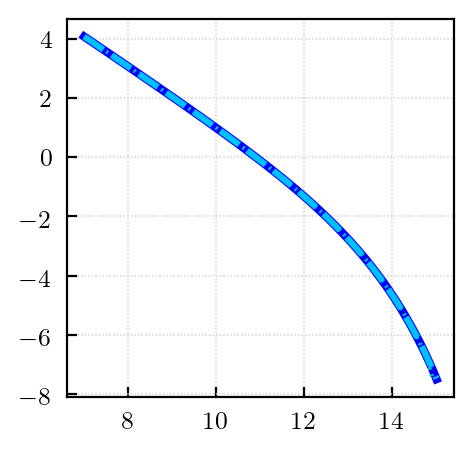

In [16]:
### example codes for "abundance matching" exercise (3)
# example of how to integrate functions
from scipy.interpolate import UnivariateSpline
from scipy.integrate import quadrature
from codes.auxiliary import romberg

# tabulate an arbitrary but fairly realistic example function
lx = np.linspace(7., 15., 100); x = 10.**lx
y = 2.77e11/x*np.exp(-(x/3.e12)**(1./3.))
ly = np.log10(y)
# construct spline in log-log space, no smoothing
yxsp = UnivariateSpline(lx, ly, s=0.0)

#define function for integration using spline
def fint(lm):
    return 10.**yxsp(lm)

ycum = np.zeros_like(lx); 
ycum2 = np.zeros_like(lx); 
ycum3 = np.zeros_like(lx);

# if one splines the function under the integral itself, one can use integral method of the spline
yxsplin = UnivariateSpline(lx, y, s=0.0)

for i, lxd in enumerate(lx):
    ycum[i] = quadrature(fint,lxd,15.5)[0]
    ycum2[i] = yxsplin.integral(lxd,np.inf)
    ycum3[i] = romberg(fint,lxd,15.5)[0]

fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
plt.plot(lx,np.log10(ycum), lw=3., c='b')
plt.plot(lx,np.log10(ycum2),':', lw=1.5, c='c')
plt.plot(lx,np.log10(ycum3),'--', lw=2.25, c='deepskyblue')

plt.grid(c='lightgray', ls='dotted')
plt.show()

Now here is how you can use splines to abundance match. We define a second function and match it to the first. Note that the first variable in UnivariateSpline must be monotonic, so *the order of arrays is reversed before this is done*. Code below does such "abundance matching" and plots the matched quantities one against the other (right panel). 

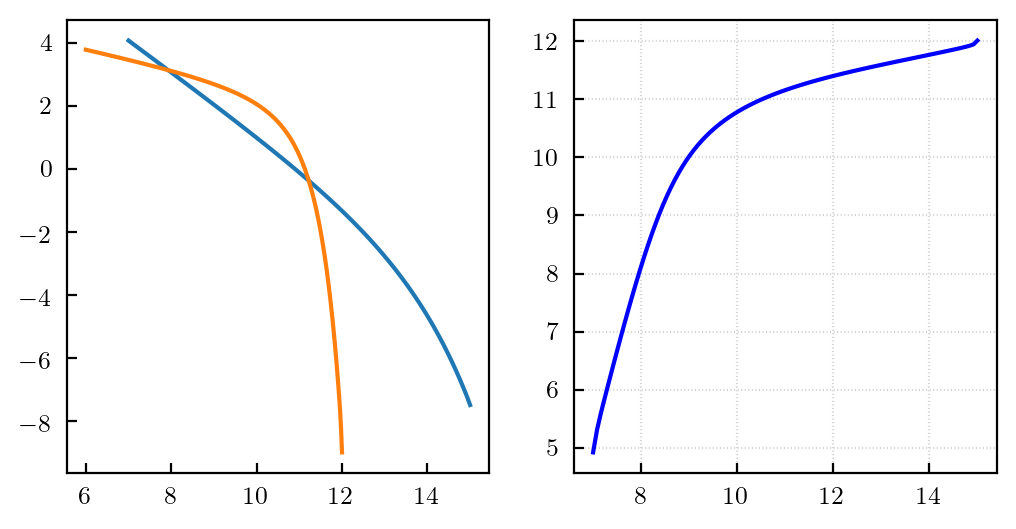

In [17]:
# tabulate an arbitrary but fairly realistic example function
lx2 = np.linspace(6., 12., 500); x2 = 10.**lx2
z = 1.e-6*2.77e11/x2**0.3*np.exp(-(x2/5.e10))
lz = np.log10(z)

zcum = np.zeros_like(lx2); 
# if one splines the function under the integral itself, one can use integral method of the spline
zxsplin = UnivariateSpline(lx2,z,s=0.0)

for i, lxd in enumerate(lx2):
    zcum[i] = zxsplin.integral(lxd,np.inf)

zcum[zcum<=0] = 1.e-9
# note that the first variable in the spline must be increasing, so we need to invert zcum
zcumr = zcum[::-1]; lx2r = lx2[::-1]
matchspl = UnivariateSpline(zcumr, lx2r, s=0.0)

lxmatch = matchspl(ycum2)

fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(lx, np.log10(ycum)); ax[0].plot(lx2, np.log10(zcum))

ax[1].plot(lx, lxmatch,  c='b')

ax[1].grid(ls='dotted', c='lightgray')
plt.show()